# Extracting Functional Connectivity Matrix from Empirical Data

Following Nilearn tutorial found at: https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py

In [74]:
import pandas as pd
import numpy as np 
import json

from nilearn import plotting
from nilearn import image

from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import NiftiLabelsMasker
from nilearn.interfaces.fmriprep import load_confounds, load_confounds_strategy

In [5]:
# ATLAS_FILE_PATH = "../../data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz"
FMRI_FILE_PATH = "../../data/adni/sub-ADNI002S0295/ses-M060/func/sub-ADNI002S0295_ses-M060_task-rest_space-MNI152Lin_res-2_desc-preproc_bold.nii.gz"
CONFOUNDS_FILE_PATH = "../../data/adni/sub-ADNI002S0295/ses-M060/func/sub-ADNI002S0295_ses-M060_task-rest_desc-confounds_timeseries.tsv"

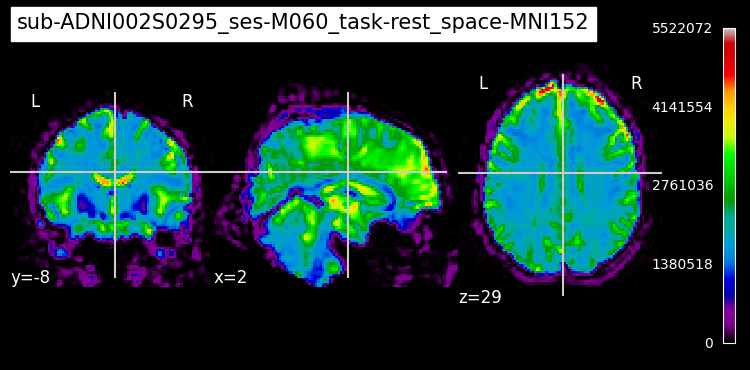

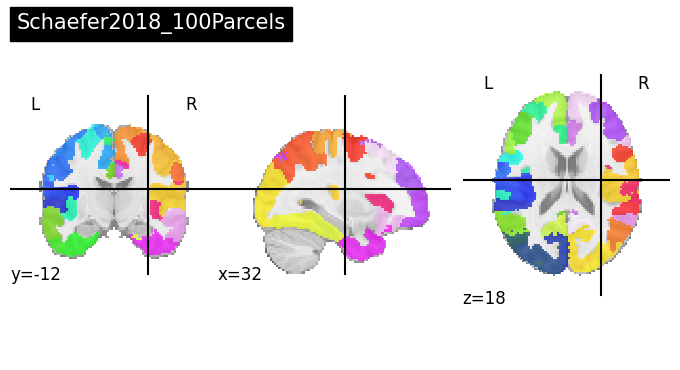

In [6]:
# Retrieve Schaefer Atlas
from nilearn import datasets 

atlas_dataset = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=2)
atlas_map = atlas_dataset.maps
atlas_labels = atlas_dataset.labels

# Visualising fmri + atlas
mean_fmri = image.mean_img(FMRI_FILE_PATH)
plotting.plot_epi(mean_fmri, colorbar=True, cbar_tick_format="%i", title="sub-ADNI002S0295_ses-M060_task-rest_space-MNI152")

plotting.plot_roi(atlas_map, title="Schaefer2018_100Parcels")



## Compute Correlation Matrix

In [84]:
def compute_fc(masker, fmri_data, trial_name, confounds = None, strategy = None, sample_mask = None):

    if confounds is not None:
        confound_data = {
            'Shape':  confounds.shape,
            'Columns': confounds.columns.values.tolist()
        }

        confounds=confounds.values
    else:
        confound_data = None
    
    if strategy is not None:
        confounds, sample_mask = load_confounds_strategy(
            img_files=fmri_data,
            **strategy
        )

        confound_data = {
            'Confounds_strategy': strategy,
            'Shape':  confounds.shape,
            'Columns': confounds.columns.values.tolist()
        }
    
    with open(f'fc_trials/{trial_name}.json', 'w') as f:
        f.write(json.dumps(confound_data))

    time_series = masker.fit_transform(fmri_data, confounds=confounds, sample_mask=sample_mask)

    correlation_measure = ConnectivityMeasure(
        kind="correlation",
        standardize="zscore_sample",
    )
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]

    print(correlation_matrix)

    # Make a large figure
    # Mask the main diagonal for visualization:
    np.fill_diagonal(correlation_matrix, 0)
    plot = plotting.plot_matrix(
        correlation_matrix,
        figure=(15, 12),
        labels=atlas_labels,
        vmax=0.8,
        vmin=-0.8,
        title=trial_name,
        reorder=True,
    )

    fig = plot.get_figure()
    fig.savefig(f'fc_trials/{trial_name}.png')

    plotting.show()

In [99]:
# DEFINE MASK

# Extracting signals on a parcellation defined by atlas parcellations
masker = NiftiLabelsMasker(
    labels_img=atlas_map,
    standardize="zscore_sample",
    standardize_confounds=True,
    high_variance_confounds=True,
    memory="nilearn_cache",
    verbose=5
)


### Empirical Confound Removal

Remove a selected set of empirical confounds from the fMRI data

In [98]:
# PREPROCESSING CONFOUNDS

# Remove NaNs from the Confound File - ignore time step 1 and select a subset of confounds

df = pd.read_csv(CONFOUNDS_FILE_PATH, sep='\t')
confounds = df.iloc[1:, :104]

print("The shape of the confounds matrix is:", confounds.shape)
print(confounds.columns.values)

The shape of the confounds matrix is: (139, 104)
['global_signal' 'global_signal_derivative1'
 'global_signal_derivative1_power2' 'global_signal_power2' 'csf'
 'csf_derivative1' 'csf_power2' 'csf_derivative1_power2' 'white_matter'
 'white_matter_derivative1' 'white_matter_derivative1_power2'
 'white_matter_power2' 'csf_wm' 'tcompcor' 'std_dvars' 'dvars'
 'framewise_displacement' 'rmsd' 't_comp_cor_00' 't_comp_cor_01'
 't_comp_cor_02' 't_comp_cor_03' 't_comp_cor_04' 't_comp_cor_05'
 'c_comp_cor_00' 'c_comp_cor_01' 'c_comp_cor_02' 'c_comp_cor_03'
 'c_comp_cor_04' 'c_comp_cor_05' 'c_comp_cor_06' 'w_comp_cor_00'
 'w_comp_cor_01' 'w_comp_cor_02' 'w_comp_cor_03' 'w_comp_cor_04'
 'w_comp_cor_05' 'w_comp_cor_06' 'w_comp_cor_07' 'w_comp_cor_08'
 'w_comp_cor_09' 'w_comp_cor_10' 'w_comp_cor_11' 'w_comp_cor_12'
 'w_comp_cor_13' 'w_comp_cor_14' 'w_comp_cor_15' 'w_comp_cor_16'
 'w_comp_cor_17' 'w_comp_cor_18' 'w_comp_cor_19' 'w_comp_cor_20'
 'w_comp_cor_21' 'w_comp_cor_22' 'w_comp_cor_23' 'a_comp_co

[NiftiLabelsMasker.wrapped] loading data from /Users/dyutichakraborty/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[Memory]1.7s, 0.0min    : Loading high_variance_confounds...
_____________________________high_variance_confounds cache loaded - 0.0s, 0.0min
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x15aea3410>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x2cd249a50>, { 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': True,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/Users/dyutichakraborty/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  '

/Users/dyutichakraborty/Library/CloudStorage/OneDrive-Personal/University/Year 4/FYP/code/ad_modelling_fyp/nilearn/maskers/nifti_labels_masker.py:670: UserWarning: Persisting input arguments took 1.75s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  region_signals, (ids, masked_atlas) = self._cache(


_______________________________________________filter_and_extract - 5.8s, 0.1min
[[ 1.         -0.11829179  0.1330531  ... -0.21915181  0.08429342
  -0.02485824]
 [-0.11829179  1.          0.23763882 ...  0.10149305 -0.0787545
  -0.18051386]
 [ 0.1330531   0.23763882  1.         ...  0.12365407 -0.07669691
  -0.10331584]
 ...
 [-0.21915181  0.10149304  0.12365407 ...  1.          0.3000797
  -0.0313715 ]
 [ 0.08429342 -0.0787545  -0.07669691 ...  0.3000797   1.
   0.3381505 ]
 [-0.02485824 -0.18051386 -0.10331584 ... -0.0313715   0.3381505
   1.        ]]


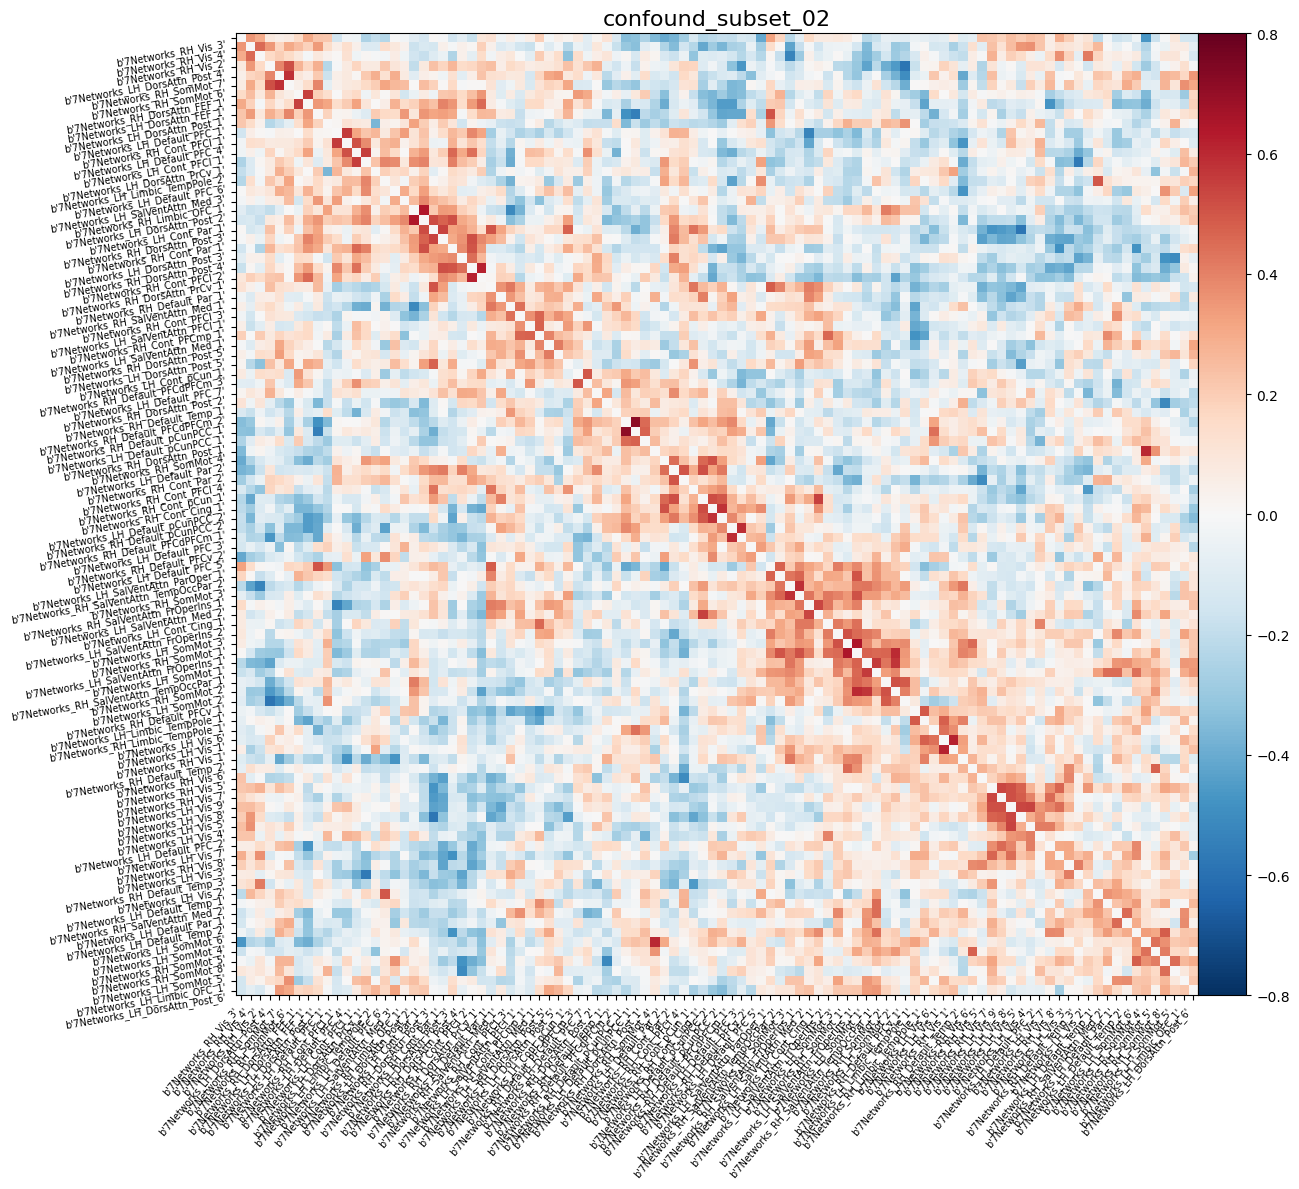

In [100]:
fmri = image.load_img(FMRI_FILE_PATH)
fmri = image.index_img(fmri, slice(1, None))

# Confound Removal
compute_fc(masker=masker, confounds=confounds, fmri_data=fmri, trial_name='confound_subset_02')

### No Confound Removal

Plots FC without removing any of the empirical confound data

[NiftiLabelsMasker.wrapped] loading data from /Users/dyutichakraborty/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[Memory]89.2s, 1.5min   : Loading high_variance_confounds...
_____________________________high_variance_confounds cache loaded - 0.0s, 0.0min
[Memory]91.3s, 1.5min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[[1.         0.33128455 0.35503143 ... 0.03078805 0.37243384 0.17743354]
 [0.33128452 1.         0.4525907  ... 0.20649403 0.33078104 0.32162467]
 [0.3550314  0.4525907  1.         ... 0.3268141  0.31841916 0.36823675]
 ...
 [0.03078805 0.20649403 0.3268141  ... 1.         0.12534904 0.40184608]
 [0.37243384 0.33078104 0.31841916 ... 0.12534904 1.         0.30075735]
 [0.17743354 0.32162467 0.36823675 ... 0.4018461  0.30075735 1.        ]]


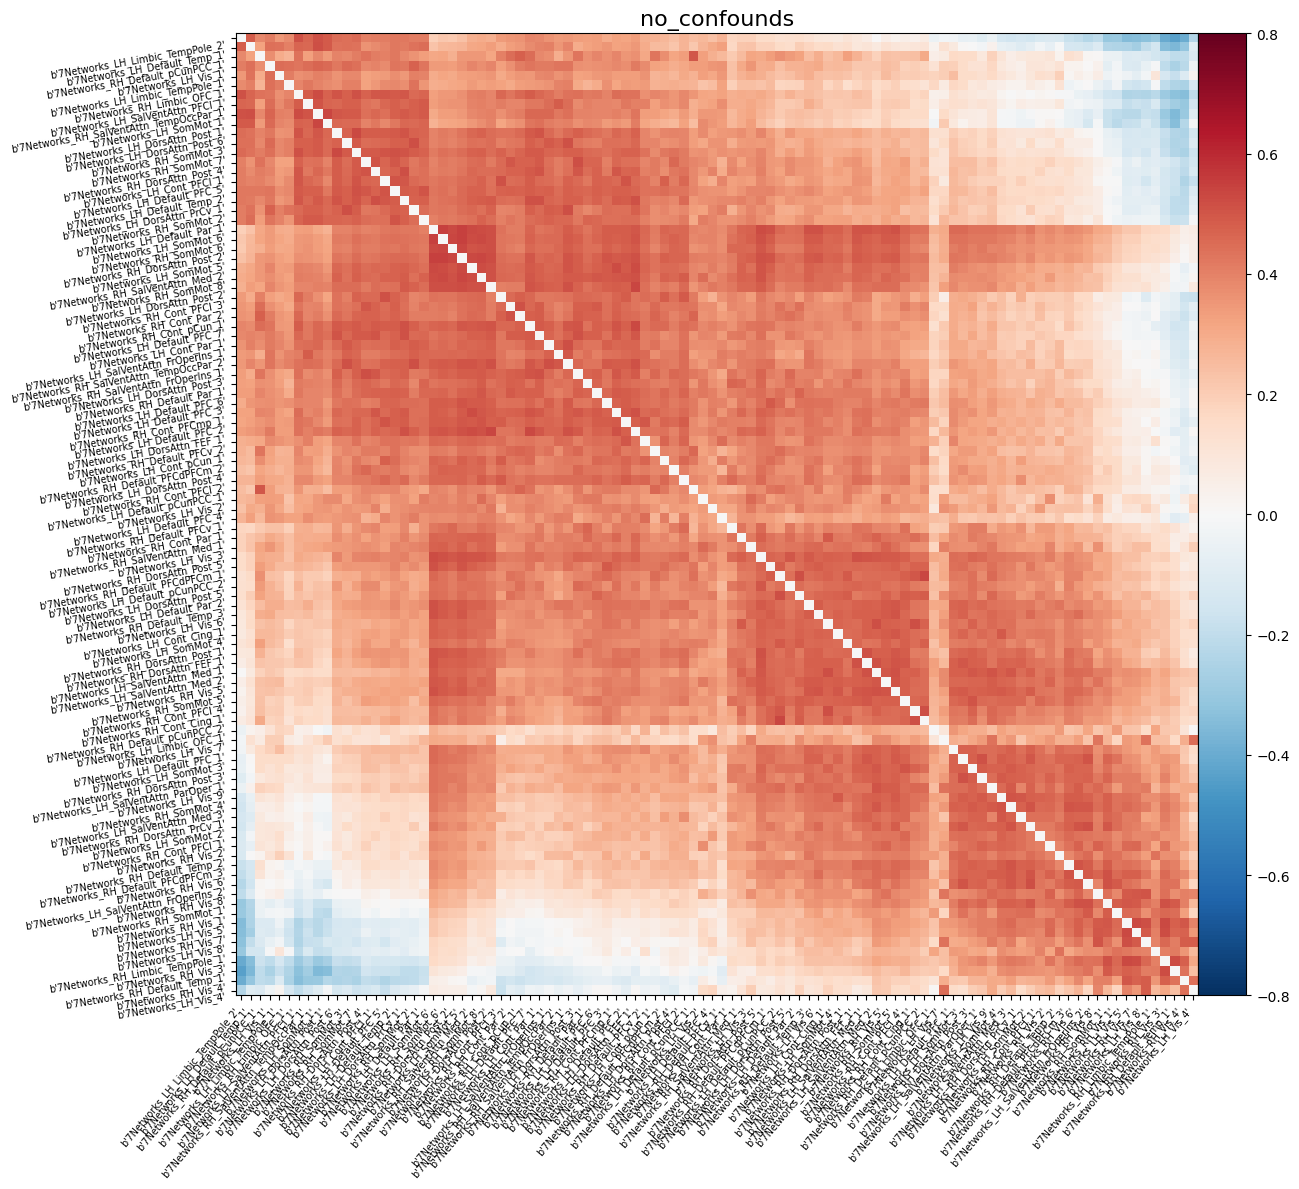

In [101]:
# No Confound Removal
compute_fc(masker=masker, fmri_data=FMRI_FILE_PATH, trial_name='no_confounds')

### Use a Pre-defined Confound Removal Strategy

Use one of Nilearn's pre-defined confound removal strategy, namely compcor:

- 'compcor': Load confounds using the CompCor strategy from Behzadi2007. CompCor estimates noise through principal component analysis on regions that are unlikely to contain signal. Thus it might not be a suitable approach for researchers who want explicit description of the source of noise. Empirically, Compcor has shown similar effect of removing physiological noise as methods that explicitly model and remove physiology signals. Compcor can suffer from loss of temporal degrees of freedom when using explained variance as the noise component estimation as the number of compcor component can be really high. Please refer to fMRIPrep documentation for more details.

[NiftiLabelsMasker.wrapped] loading data from /Users/dyutichakraborty/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[Memory]172.6s, 2.9min  : Loading high_variance_confounds...
_____________________________high_variance_confounds cache loaded - 0.0s, 0.0min
[Memory]174.8s, 2.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[[ 1.          0.29401493  0.3005675  ... -0.1213242   0.28344685
  -0.07285915]
 [ 0.29401493  1.          0.57267255 ...  0.19606923  0.30182862
   0.1174209 ]
 [ 0.3005675   0.57267255  1.         ...  0.19016421  0.23492612
   0.07642812]
 ...
 [-0.1213242   0.19606923  0.19016421 ...  1.          0.34368014
   0.24438502]
 [ 0.28344685  0.30182865  0.23492612 ...  0.34368014  1.
   0.5285491 ]
 [-0.07285915  0.1174209   0.07642812 ...  0.24438502  0.5285491
   1.        ]]


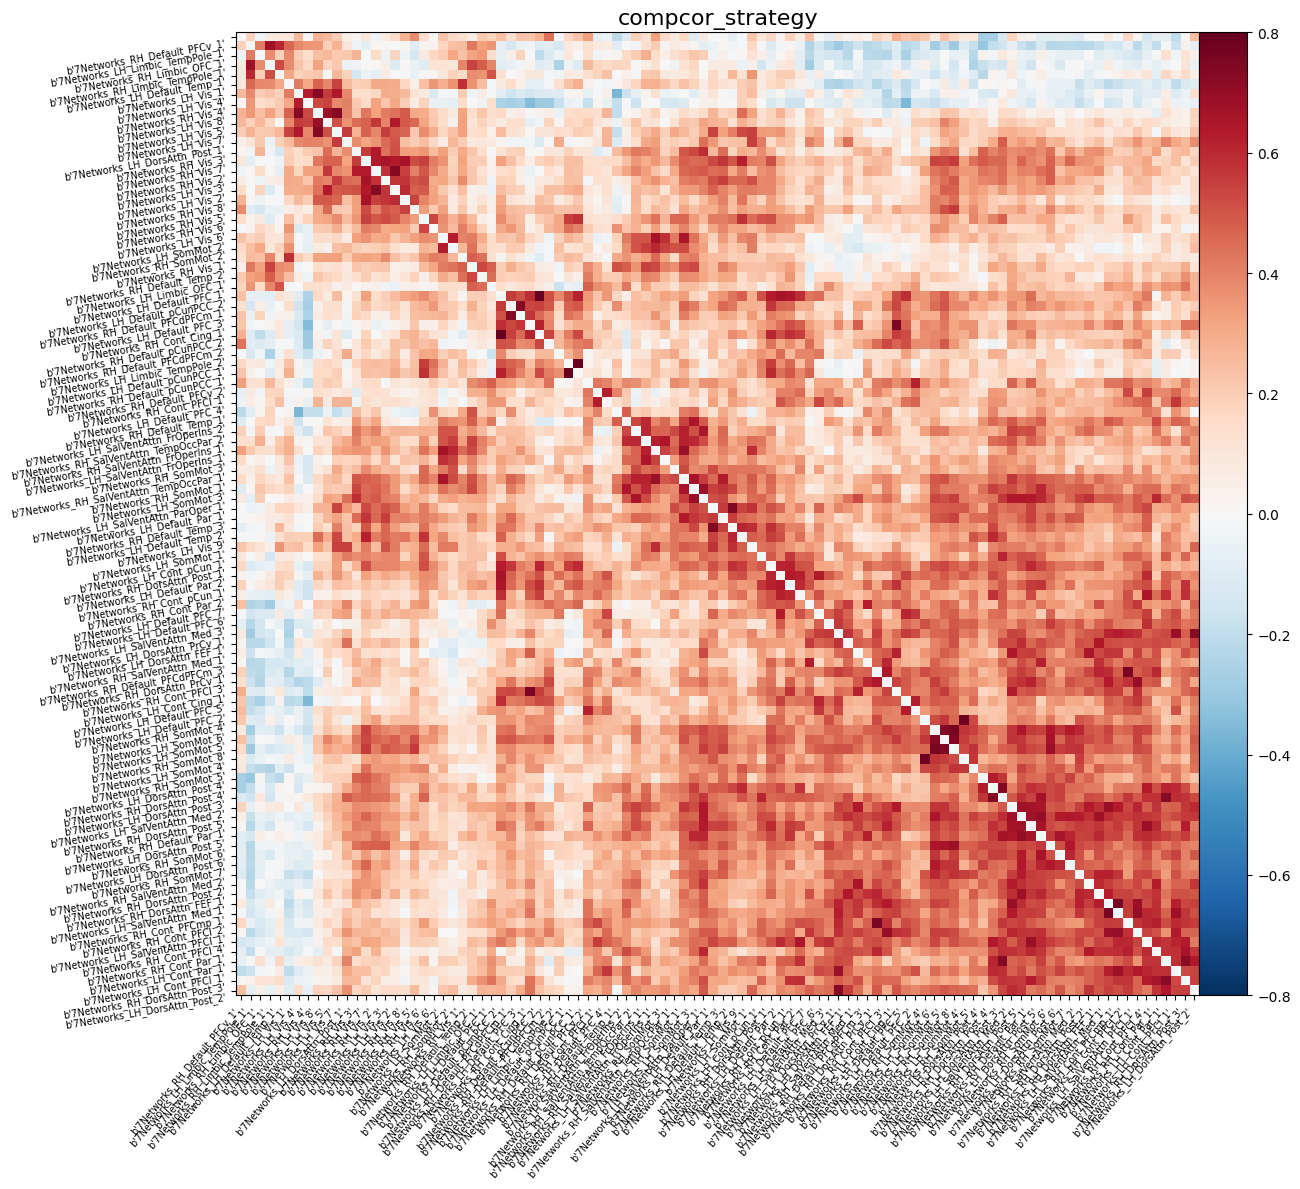

In [102]:
# Strategy
strategy = {
    'denoise_strategy' : 'compcor',
    'compcor':"anat_separated",
    'n_compcor':5
}

compute_fc(masker=masker, fmri_data=FMRI_FILE_PATH, trial_name='compcor_strategy', strategy=strategy)